# Deel II. Deep learning

## Hoofdstuk 3. Neurale netwerken

1. [Inleiding](#Inleiding)
2. [Het multi-layer perceptron](#Het_multi_layer_perceptron)
3. [Initialisatie](#Initialisatie)
4. [Forward-propagation](#Forward_propagation)
5. [Losses](#Losses)
6. [Back-propagation](#Back_propagation)

### <a id='Inleiding'>Inleiding</a>

Dit is het Jupyter Notebook behorende bij hoofdstuk 3 van het vak *Advanced Datamining* (BFVH4DMN2). Op BlackBoard tref je eveneens een module `data.py` aan die diverse functies bevat die helpen bij het genereren en het visualiseren van de gebruikte datasets. Kopieer het bestand `model.py` van het vorige hoofdstuk en sla deze bestanden gezamenlijk op in één werkmap. Open je `model` module in een code-editor naar keuze om hiermee verder te werken.

Laten we weer beginnen om deze functies te importeren, samen met wat initialisatie-code en enkele onderdelen van de modules `pandas`, `numpy` en `keras`. Plaats de cursor in de cel hieronder en druk op Ctrl+Enter (of Shift+Enter om meteen naar de volgende cel te gaan).

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from pandas import DataFrame, __version__
print(f'Using pandas version {__version__}')

from numpy import array, __version__
print(f'Using numpy version {__version__}')

from keras import models, layers, __version__
print(f'Using keras version {__version__}')

import model, data

Using pandas version 0.23.3
Using numpy version 1.16.2


Using Theano backend.


Using keras version 2.2.4


<div class="alert alert-info">**Opmerking:**<br />Als `numpy` of `keras` niet geïnstalleerd is op je systeem, voer dan `pip3 install numpy keras tensorflow` uit (of gebruik eventueel `theano` als alternatief voor `tensorflow`). Herstart de python kernel via de menu-optie `Kernel` > `Restart` van dit notebook.</div>

### <a id='Het_multi_layer_perceptron'>Het multi-layer perceptron</a>

In dit hoofdstuk gaan we de eerder gemaakte neuronen in parallelle en seriële lagen aan elkaar koppelen om krachtigere algoritmen mee te construeren. We gaan meerdere typen lagen definiëren, waaronder een input laag, lagen met neuronen die lineaire combinaties van attributen maken, afzonderlijke lagen die daar activatiefuncties op toepassen, en tenslotte nog een finale laag die een loss-functie toepast om de kwaliteit van de fit te berekenen. Omdat de lagen eigenschappen delen leent deze opzet zich bij uitstek voor een object-georiënteerde opzet.

We beginnen met het definiëren van onze [Mother Of All Layers](https://idioms.thefreedictionary.com/the+mother+of+all): de parent-class `Layer()` waarvan we diverse child-classes zullen afleiden. De `Layer()` class hieronder houdt een instance variabele `next` bij die verwijst naar de volgende neurale laag (of `None` als het de laatste laag betreft), vergelijkbaar met een *linked list* datastructuur. Verder wordt het aantal `inputs` naar de laag en het aantal `outputs` vanuit de laag bijgehouden. Het aantal outputs dient onmiddellijk te worden gespecificeerd tijdens het initialiseren van het `Layer()` object; het aantal inputs wordt pas bepaald middels de `set_inputs()` methode zodra de laag aan een voorafgaande laag wordt gekoppeld. Tenslotte heeft elke laag een naam opdat we opeenvolgende lagen eenvoudiger kunnen onderscheiden.

Je kan het onderstaande fragment letterlijk overnemen. Bestudeer de werking zodat je begrijpt wat deze doet.

```python
from collections import Counter

class Layer():

	classcounter = Counter()

    def __init__(self, outputs, *, name=None, next=None):
        Layer.classcounter[type(self)] += 1
        if name is None:
            name = f'{type(self).__name__}_{Layer.classcounter[type(self)]}'
        self.inputs = 0
        self.outputs = outputs
        self.name = name
        self.next = next

	def __repr__(self):
		text = f'Layer(inputs={self.inputs}, outputs={self.outputs}, name={repr(self.name)})'
		if self.next is not None:
			text += ' + ' + repr(self.next)
		return text

    def add(self, next):
        if self.next is None:
            self.next = next
            next.set_inputs(self.outputs)
        else:
            self.next.add(next)

    def set_inputs(self, inputs):
        self.inputs = inputs
```

<div class="alert alert-info">**Opmerking:**<br />Het is weliswaar mogelijk om de `set_inputs()` methode om te zetten in een *property setter* door middel van de `@property` decorator, maar omdat deze waarde gewoonlijk niet expliciet door de gebruiker zelf wordt toegekend werken we dit niet verder uit.</div>

Hieronder wordt een neuraal netwerk gedefinieerd bestaande uit een aantal lagen door gebruik te maken van de `add()` methode. Momenteel hebben de layers nog geen nuttige functionaliteit, maar de structuur van het netwerk kan wel getoond worden. Verifieer dat het aantal outputs van een voorgaande laag altijd automatisch gelijk is aan het aantal inputs van een volgende laag.

In [2]:
my_network = model.Layer(outputs=3, name='Input')
my_network.add(model.Layer(outputs=2, name='Hidden'))
my_network.add(model.Layer(outputs=1, name='Output'))
print(my_network)

Layer(inputs=0, outputs=3, name='Input') + Layer(inputs=3, outputs=2, name='Hidden') + Layer(inputs=2, outputs=1, name='Output')


Vaak construeer je modellen van vele lagen. Om de syntax wat te vereenvoudigen voegen we de onderstaande `__add__()` methode toe die het mogelijk maakt om de `+` operator te gebruiken.

```python
from copy import deepcopy

	def __add__(self, next):
		result = deepcopy(self)
		result.add(deepcopy(next))
		return result
```

Dit geeft een verkorte notatie om hetzelfde te bereiken als hierboven met de onderstaande compacte one-liner.

In [3]:
my_network = model.Layer(3, name='Input') + model.Layer(2, name='Hidden') + model.Layer(1, name='Output')
print(my_network)

Layer(inputs=0, outputs=3, name='Input') + Layer(inputs=3, outputs=2, name='Hidden') + Layer(inputs=2, outputs=1, name='Output')


Het is soms handig om toegang te hebben tot de verschillende lagen nadat het model eenmaal is gecreëerd. De onderstaande `__getitem__()` methode maakt het mogelijk om de opeenvolgende lagen te indexeren met een getalwaarde (gelijk aan het volgnummer van de laag) of een string (gelijk aan de naam van de laag) met behulp van de gebruikelijke blokhaak-notatie die ook voor lijsten of dictionairies wordt gebruikt.

```python
    def __getitem__(self, index):
		if index == 0 or index == self.name:
			return self
		if isinstance(index, int):
			if self.next is None:
				raise IndexError('Layer index out of range')
			return self.next[index - 1]
		if isinstance(index, str):
			if self.next is None:
				raise KeyError(index)
			return self.next[index]
		raise TypeError(f'Layer indices must be integers or strings, not {type(index).__name__}')
```

Voeg deze methode aan de `Layer()` class toe, en ga na dat je begrijpt hoe deze werkt. Hieronder worden beide manieren van indexeren gedemonstreerd.

In [4]:
print(my_network[2])

Layer(inputs=2, outputs=1, name='Output')


In [5]:
print(my_network['Output'])

Layer(inputs=2, outputs=1, name='Output')


<div class="alert alert-info">**Opmerking:**<br />Om deze parent class te vervolledigen kun je ook andere dunder-methoden definiëren, hoewel dit niet strict noodzakelijk is om dit notebook te kunnen uitvoeren; in het bijzonder de `__iadd__()`, `__len__()` en `__iter__()` methoden liggen voor de hand.</div>

### <a id='Initialisatie'>Initialisatie</a>

We hebben nu weliswaar een elegant raamwerk dat ons in staat stelt om neurale lagen aan elkaar te koppelen, maar op dit moment doen de lagen nog helemaal niets nuttigs. Daarom gaan we eerst diverse child-classes creëren  waaraan we concrete functionaliteit kunnen toevoegen.

We beginnen met het afleiden van een invoerlaag waarmee de gebruiker exclusief interactie zal hebben. We zullen hier straks onder andere de inmiddels bekende `predict()` en `fit()` methoden aan toevoegen, maar voorlopig hoeft deze laag nog geen andere functionaliteit te bevatten dan diens parent-class `Layer()`. We passen alleen de `__repr__()` methode ietsjes aan.

```python
class InputLayer(Layer):
	
	def __repr__(self):
		text = f'InputLayer(outputs={self.outputs}, name={repr(self.name)})'
		if self.next is not None:
			text += ' + ' + repr(self.next)
		return text
```

Wanneer we nu een model opzetten met daarin de `InputLayer()` class als invoerlaag krijgen we netjes te zien dat het hier om een `InputLayer()` gaat; de `inputs` parameter is hiervoor niet relevant en wordt dan ook niet weergegeven.

In [6]:
my_network = model.InputLayer(3, name='Input')
print(my_network)

InputLayer(outputs=3, name='Input')


De volgende stap is om de verborgen lagen te implementeren. Deze bestaan elk eigenlijk uit een parallelle serie van neuronen, zoals die in de vorige les gedefinieerd zijn. Elk neuron ontvangt een aantal invoerwaarden zoals aangegeven in de instance-variable `inputs`, en in totaal heeft de laag een breedte gegeven door de instance-variable `outputs`.

Een neuron in een multi-layer perceptron voert twee operaties uit: de inputs worden gewogen met gewichten en samen met een bias opgeteld; en, op de uitkomst hiervan wordt een activatiefunctie toegepast. In tegenstelling tot de vorige les, waar één `Neuron()` class beide functionaliteiten bevatte, zullen we er hier voor kiezen om deze op te splitsen in twee aparte child-classes van de `Layer()` class: een class `Dense()` die de gewogen lineaire combinatie uitvoert, en een class `Activation()` die de activatiefunctie toepast.

Maak eerst de child-class `Dense()` aan en begin weer met het overriden van de representatie-methode. Het zit echter wat ingewikkelder met de initialisatie. Omdat neurale lagen meerdere parallelle neuronen bevatten zullen ook de biases en gewichten meervoudig worden uitgevoerd. De biases kunnen worden bijgehouden in een lijst met één index die overeenkomt met het nummer $o$ van het uitvoerneuron in de laag; de gewichten vereisen een geneste lijst met twee indices die overeenkomen met het nummer $o$ van het uitvoerneuron en het nummer $i$ van de invoer naar het neuron. Echter, ten tijde van het instantiëren van een instance met `__init__()` is nog niet bekend hoeveel `inputs` $i$ deze gaat hebben; dat gebeurt pas wanneer de laag aan een netwerk wordt toegevoegd middels de `set_inputs()` methode.

Maak daarom de instance-variabele `weights` weliswaar aan tijdens het instantiëren, maar vul deze pas met waarden in de `set_inputs()` methode zodra het aantal inputs bekend is. In tegenstelling tot de `Neuron()` class mogen de gewichten hier niet allemaal nul zijn. Deze worden geïnitialiseerd met een uniforme random waarde tussen $\pm\sqrt{\frac{6}{N_{\text{in}}+N_{\text{uit}}}}$, met $N_{\text{in}}$ en $N_{\text{uit}}$ gelijk aan het aantal inkomende en uitgaande verbindingen van een neuron.

Denk zelf na waar je de `bias` kan initialiseren, en met welke waarden dit dan zou moeten.

<div class="alert alert-info">**Opmerking:**<br />Wanneer een child-class de `__init__()` methode van de parent-class override, dan kun je middels `super().__init__(...)` de instantiatie-methode van de parent-class aanroepen om diens instance-variabelen te initialiseren.</div>

Hieronder wordt eerst een `Dense()` layer aangemaakt, en vervolgens toegevoegd aan de eerder gecreëerde `InputLayer()`.

In [7]:
my_layer = model.Dense(2, name='Dense')
print(my_layer)
print(f'- bias = {my_layer.bias}')
print(f'- weights = {my_layer.weights}')

Dense(outputs=2, name='Dense')
- bias = [0.0, 0.0]
- weights = [[], []]


In [8]:
my_network.add(my_layer)
print(my_network)
print(f'- bias = {my_network[1].bias}')
print(f'- weights = {my_network[1].weights}')

InputLayer(outputs=3, name='Input') + Dense(outputs=2, name='Dense')
- bias = [0.0, 0.0]
- weights = [[-0.01670853954662599, 0.8629311520206542, -0.5995042269792439], [-0.22653213034087638, -1.0663233596767965, -0.8789004257055948]]


Maak vervolgens de child-class `Activation()` aan en override de instantiatie- en representatie-methodes. De instance-variabele `activation` bevat de activatiefunctie, met opnieuw als default de `linear()` functie. Deze dient geïnitialiseerd te worden in de `__init__()` methode en getoond te worden door de `__repr__()` methode.

Controleer hieronder dat je `Activation()` laag juist wordt aangemaakt, weergegeven, en aan het netwerk toegevoegd.

In [9]:
my_layer = model.Activation(2, name='Activation')
print(my_layer)

Activation(inputs=0, outputs=2, activation=linear, name='Activation')


In [10]:
my_network.add(my_layer)
print(my_network)

InputLayer(outputs=3, name='Input') + Dense(outputs=2, name='Dense') + Activation(inputs=2, outputs=2, activation=linear, name='Activation')


De laatste child-class in dit hoofdstuk is de `OutputLayer()`. Wij zullen de laatste laag gebruiken om de loss te berekenen. Deze laag zal dus een instance-variabele moeten hebben die de door de gebruiker gewenste loss-functie bevat.

<div class="alert alert-info">**Opmerking:**<br />Normaal wordt de laatste laag die de predictie als uitvoer geeft betiteld als output laag. Omdat wij ons model afsluiten met een extra laag die de loss berekent, wijken we hier enigszins van deze naamgeving af. Onze `OutputLayer()` class krijgt de predictie juist als invoer binnen.</div>

Omdat de `OutputLayer()` class de laatste laag is, heeft deze nul `outputs` (net zoals de `InputLayer()` nul inputs heeft). De `inputs` en de volgende laag `next` hoeven dus ook niet te worden gespecificeerd bij de instantiatie en niet te hoeven weergegeven in de representatie. Je krijgt dan een instantiatie-methode met een signatuur als `__init__(self, loss=mean_squared_error, *, name=None)`; pas zelf de representatie-methode aan.

Het voorgaande betekent ook dat er geen extra lagen mogen worden toegevoegd aan een instance van `OutputLayer()`. Dit kun je afdwingen door de `add()` methode van de parent-class `Layer()` te overriden met een functie die slechts een `NotImplementedError()` genereert. En nu we toch bezig zijn, dit kun je ook doen voor de `set_inputs()` methode van de `InputLayer()`, aangezien de invoerlaag niet mag worden gekoppeld aan een voorgaande laag.

Hieronder maken we ook deze laatste laag aan, en voegen we deze aan het eerder opgebouwde netwerkje toe.

In [11]:
my_layer = model.OutputLayer(name='Output')
print(my_layer)

OutputLayer(inputs=0, loss=mean_squared_error, name='Output')


In [12]:
my_network.add(my_layer)
print(my_network)

InputLayer(outputs=3, name='Input') + Dense(outputs=2, name='Dense') + Activation(inputs=2, outputs=2, activation=linear, name='Activation') + OutputLayer(inputs=2, loss=mean_squared_error, name='Output')


Nu je dit allemaal voor elkaar hebt kun je hieronder op een simpele manier in één keer een neuraal netwerk aanmaken waarin alle soorten lagen voorkomen.

In [13]:
my_network = model.InputLayer(3) + model.Dense(2) + model.Activation(2) + model.OutputLayer()
print(my_network)

InputLayer(outputs=3, name='InputLayer_2') + Dense(outputs=2, name='Dense_2') + Activation(inputs=2, outputs=2, activation=linear, name='Activation_2') + OutputLayer(inputs=2, loss=mean_squared_error, name='OutputLayer_2')


<div class="alert alert-success">**Gefeliciteerd!**<br />Je kan nu op flexibele wijze neurale netwerken opzetten met invoerlagen, verscheidene verborgen lagen, en uitvoerlagen.</div>

Met deze kleine mijlpaal achter de rug is nu het moment aangebroken om een nieuwe dataset te introduceren met slechts een viertal instances. Je kunt deze opvragen met de functie `data.xorproblem()`.

In [14]:
xs, ys = data.xorproblem()
DataFrame(xs, columns=['x1', 'x2']).assign(y=DataFrame(ys))

x1   x2    y
0 -1.0 -1.0 -1.0
1  1.0 -1.0  1.0
2 -1.0  1.0  1.0
3  1.0  1.0 -1.0

Hopelijk herken je in deze dataset het *XOR-probleem*.

<div class="alert alert-info">**Opmerking:**<br />Omdat neurale lagen meerdere outputs kunnen hebben bestaan de klasselabels in de variabele `ys` niet simpelweg meer uit een lijst getalwaarden, maar uit een geneste lijst. In dit geval is er maar één output, dus bevatten de geneste lijsten elk maar één element.</div>

Ga in de grafiek hieronder na dat deze data niet lineair separabel zijn.

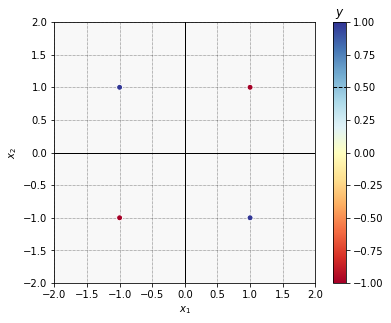

In [15]:
data.scatter(xs, ys)

Tot dusverre was dit werkcollege voornamelijk copy/paste, maar nu komt een lastig stukje waarin we ons neurale netwerk functioneel gaan maken. We zullen het neurale netwerk enerzijds moeten leren om in de *forward-propagation* fase uit gegeven attributen aan de invoerzijde een predictie af te leiden aan de uitvoerzijde, en om anderzijds in de *back-propagation* fase voor een bepaalde predictie aan de uitvoerzijde een loss te berekenen en met de gradiënten hiervan terugwerkend naar de invoerzijde de biases en gewichten bij te werken.

We zullen voor beide taken gebruik maken van de `__call__()` methode van de child-classes. Deze zorgen ervoor dat een object kan worden aangeroepen alsof het zelf een functie is. Deze `__call__()` methode kan voor de parent-class `Layer()` niet zinvol geïmplementeerd worden omdat elk type laag een andere functie heeft. Omdat deze daarentegen wel door elke child-class gedefinieerd dient te worden, is dit een voorbeeld van een *abstracte* methode. We implementeren deze in de parent-class `Layer()` door slechts een foutmelding te genereren.

```python
    def __call__(self, xs):
        raise NotImplementedError('Abstract __call__ method')
```

<div class="alert alert-info">**Opmerking:**<br />De `abc` module met *abstract base classes* biedt een betere manier om in Python abstracte methoden te definiëren. Deze zou het echter onmogelijk maken om rechtstreeks een `Layer()` instance te instantiëren, hetgeen hier iets te ver voert.</div>

Hieronder zie je de syntax waarmee een laag nu als een functie kan worden aangeroepen, zij het dat je een foutmelding zal krijgen omdat deze functie voor de `Layer()` class abstract is.

In [16]:
try:
    my_layer = model.Layer(outputs=5)
    ys = my_layer(xs)   # De Layer instance kan worden aangeroepen als een functie!
except NotImplementedError:
    print('OEPS!')

OEPS!


### <a id='Forward_propagation'>Forward-propagation</a>

We implementeren eerst weer de methoden die zorgen voor predictie. Dit kan recursief geïmplementeerd worden, waarbij elke laag de volgende laag aanroept totdat de recursie beëindigd wordt door de laatste laag. Je mag ervan uitgaan dat de laatste laag in het netwerk altijd een `OutputLayer()` zal zijn. Deze moet immers de kwaliteit van de uiteindelijk gemaakte voorspelling beoordelen met behulp van de loss-functie, want deze uitkomst is hetgeen je wil optimaliseren.



Van achteren naar voren terug redenerend gelden dan de volgende uitgangspunten:

* Een `OutputLayer()` krijgt de invoerwaarden van een (geneste) lijst instances `xs` binnen. Die invoer komt uit de laatste laag van het model, dus dat vormt reeds de voorspellingen $\boldsymbol{\hat{y}}$ van het model. De `OutputLayer()` kan daardoor rechtstreeks de invoer retourneren als voorspelling. Zoals gezegd gebruiken we de `__call__()` methode. Vul de onderstaande code aan.

```python
    def __call__(self, xs):
        yhats = ...
        return yhats
```

* De `Dense()` en `Activation()` lagen krijgen invoer binnen van een vorige laag, berekenen hieruit (middels lineaire combinatie of activatiefunctie) voor elke instance een pre- of post-activatiewaarde $\boldsymbol{a}$ of $\boldsymbol{h}$, en geven die door aan de volgende laag. De volgende laag gaat hier vervolgens de predictie mee vervolgen. De voorspelling die die volgende laag uiteindelijk rapporteert wordt tenslotte ook geretourneerd als eigen voorspelling.

```python
    def __call__(self, xs):
        hs = []
        for x in xs:
            h = []
            for o in range(self.outputs):
                # Bereken voor elk neuron o uit de invoerwaarden x de uitvoerwaarden h
                h.append(...)
            hs.append(h)
        yhats = self.next(...)
        return yhats
```

<div class="alert alert-info">**Opmerking:**<br />Hierboven worden `for`-`append()`-loops gesuggereerd om de uitvoeren $\boldsymbol{h}$ van de laag te berekenen, maar deze opzet leent zich ook uitstekend voor efficiëntere (geneste) list comprehensions.</div>

* De `InputLayer()` ontvangt zijn input van de gebruiker en kan deze onveranderd doorgeven aan de eerstvolgende hidden layer. De predictie die door die layer wordt geretourneerd kan weer rechtstreeks terug naar de gebruiker. Denk zelf na wat dit betekent voor de `__call__()` methode van de invoerlaag. Voeg ook een `predict()` methode toe die nu een eenvoudige wrapper is om de `__call__()` methode ten behoeve van de gebruiker.

```python
    def predict(self, xs):
        yhats = self(xs)
        return yhats
```

Implementeer op deze manier de `__call__()` methoden voor alle child-classes. Je kan hierbij vermoedelijk putten uit je uitwerking van het `Neuron()`.

De onderstaande code zet een neuraal netwerk op met meerdere lagen en stelt de biases en gewichten zo in dat de *XOR*-dataset correct gemodelleerd zou moeten worden.

In [17]:
my_network = model.InputLayer(2) + model.Dense(2) + model.Activation(2, activation=model.sign) + model.Dense(1) + model.OutputLayer()
my_network[1].bias = [1.0, -1.0]
my_network[1].weights = [[1.0, 1.0], [1.0, 1.0]]
my_network[3].bias = [-1.0]
my_network[3].weights = [[1.0, -1.0]]

data.scatter(xs, ys, model=my_network)
print(my_network)

InputLayer(outputs=2, name='InputLayer_3') + Dense(outputs=2, name='Dense_3') + Activation(inputs=2, outputs=2, activation=sign, name='Activation_3') + Dense(outputs=1, name='Dense_4') + OutputLayer(inputs=1, loss=mean_squared_error, name='OutputLayer_3')


Verifieer hieronder dat alle instances exact juist voorspeld worden.

In [18]:
yhats = my_network.predict(xs)
DataFrame(xs, columns=['x1', 'x2']).assign(y=DataFrame(ys), ŷ=DataFrame(yhats))

x1   x2    y    ŷ
0 -1.0 -1.0 -1.0 -1.0
1  1.0 -1.0  1.0  1.0
2 -1.0  1.0  1.0  1.0
3  1.0  1.0 -1.0 -1.0

Je ziet dat alle punten nu correct worden geclassificeerd. In dit geval loopt er een blauwe band diagonaal naar beneden; een andere correcte oplossing zou een rode band kunnen bevatten die diagonaal naar boven loopt. Probeer de bias en gewichten eens aan te passen om die andere oplossing te bereiken.

### <a id='Losses'>Losses</a>

De `predict()` methode is nuttig om voorspellingen te genereren voor nieuwe testdata. Echter, voor bestaande trainingsdata weten we de gewenste uitkomsten al. Dan is het zinvol om ook de loss te kunnen berekenen om een idee te hebben hoe goed ons model is. Immers, hoe beter het voorspellingen, hoe lager de loss.

We zullen daartoe de bestaande `__call()__` methoden uitbreiden zodat ze niet alleen de predicties `yhats` maar ook de losses `ls` retourneren. De losses bestaan uit een lijst met voor elke instance $n$ één getalwaarde $l_n = \sum_o \mathcal{L} \left( \hat{y}_{no}; y_{no} \right)$, waarbij $o$ loopt over alle outputs van het model. Deze zullen door de `OutputLayer()` berekend moeten worden, aangezien deze de loss-functie kent.

Maak de methode van de uitvoerlaag zo dat je de correcte uitkomsten `ys` niet per se hoeft mee te geven als parameter:

* als de $\boldsymbol{y}$ *niet* worden meegegeven bereken je *alleen* de predicties $\boldsymbol{\hat{y}}$;

* als de $\boldsymbol{y}$ *wel* worden meegegeven bereken je daarnaast *ook* de losses $l$.

Je krijgt zoiets als hieronder.

```python
    def __call__(self, xs, ys=None):
        yhats = ...
        if ys is None:
            ls = None
        else:
            ls = ...
        return yhats, ls
```

De andere lagen hoeven het resultaat alleen maar door te geven van de volgende naar de vorige laag.

Tenslotte voegen we een methode `evaluate()` toe aan onze `InputLayer()` class die de *gemiddelde* loss over alle instances bepaalt. Daarvoor kunnen we weer volstaan met een simpele wrapper methode naar de gebruiker toe. In deze methode zijn de `ys` niet optioneel.

```python
    def evaluate(self, xs, ys):
        _, ls = self(xs, ys)
        lmean = sum(ls) / len(ls)
        return lmean
```

<div class="alert alert-info">**Opmerking:**<br />De `predict()` methode zal ietwat aangepast moeten worden om om te gaan met het feit dat nu ook een resultaat voor de losses wordt geretourneerd, hoewel dat daar niet daadwerkelijk gebruikt wordt.</div>

We testen de code hieronder. Als het goed is kun je nu zien dat in het voorgaande voorbeeld met de *XOR*-dataset inderdaad alle punten juist geclassificeerd werden: de loss is voor alle instances gelijk aan de laagst mogelijke waarde, dat wil zeggen nul.

In [20]:
lmean = my_network.evaluate(xs, ys)
print(f'De gemiddelde loss is gelijk aan {lmean:.3f}.')

TypeError: 'NoneType' object is not iterable

### <a id='Back_propagation'>Back-propagation</a>

Hierboven hebben we zelf de biases en gewichten ingesteld om te zorgen dat het model de *XOR*-dataset kon beschrijven. Voor algemene datasets is dat meestal niet zo eenvoudig natuurlijk. Om op een systematischere manier algemene oplossingen te vinden voor de modelparameters in een multi-layer perceptron zullen we opnieuw de optimalisatie-methode gebaseerd op gradiënt descent moeten toepassen. De algemene vorm van de update-regel luidt:

$$
\left\{ \begin{array}{c}
b\leftarrow b-\alpha\cdot\frac{\partial l}{\partial b}\\
w_{i}\leftarrow w_{i}-\alpha\cdot\frac{\partial l}{\partial w_{i}}
\end{array}\right.
$$

Daartoe dienen we voor de bias en gewichten van elk neuron in elke `Dense()` layer te bepalen hoe de loss-functie verandert als die parameters gewijzigd worden.

We beginnen te kijken hoe de loss afhangt van de *input* van elke layer. Oftewel, als we de invoer `xs` van een laag een klein beetje zouden kunnen verhogen of verlagen, hoe verandert dan de loss van het model voor de huidige instance? In formulevorm, hoe groot is $\frac{\partial l}{\partial x_{i}}$? We zullen hierbij terugwerken van de uitvoerlaag richting de invoerlaag. Bestudeer sectie *3.3. Back-propagation* van de Syllabus zodat je weet hoe dit proces in zijn werk gaat.

Voor de uitvoerlaag zelf kan de afgeleide van de loss naar diens invoer $\frac{\partial l}{\partial x_i}$ numeriek worden bepaald door de functie `derivative()` toe te passen op de loss-functie. Immers, voor de uitvoerlaag is de invoer $\boldsymbol{x}$ gelijk aan de voorspelling $\boldsymbol{\hat{y}}$, waardoor $\frac{\partial l}{\partial x_i} = \frac{\partial l}{\partial \hat{y}_i} =\frac{\partial}{\partial \hat{y}_i} \mathcal{L}(\hat{y}_i; y_i) = \mathcal{L}'(\hat{y}_i; y_i)$.

We breiden de definitie van de `__call__()` methode van de `OutputLayer()` nog een (laatste) maal uit zodat deze naast de predicties en losses ook de gradiënten van de loss $\boldsymbol{\nabla}_\boldsymbol{x} l$ als retourwaarde `gs` geeft. Omdat we de gradiënten alleen nodig hebben als we het model trainen, en we hierbij een learning rate $\alpha$ zullen moeten specificeren, spreken we af dat de gradiënten alleen berekend hoeven te worden als een parameter `alpha` is meegegeven aan de functie. De code komt er dan ongeveer als volgt uit te zien:

```python
    def __call__(self, xs, ys=None, alpha=None):
        yhats = ...
        if ys is None:
            ls = None
        else:
            ls = ...
            if alpha is None:
                gs = None
            else:
                gs = ...
        return yhats, ls, gs
```

Voor de `Dense()` en `Activation()` layers geldt, net als voor de losses, dat ze uitkomsten binnenkrijgen van de volgende laag. In tegenstelling tot de losses `ls` kunnen de gradiënten `gs` niet gewoon worden doorgegeven.

* Als de `Activation()` layer een gradiënt binnenkrijgt van de volgende laag gelijk aan $\boldsymbol{q}$, dan is dit de gradiënt van de loss naar de invoer van de volgende laag, oftewel naar de uitvoer van de huidige laag. De laag krijgt dus een lijst met waarden $q_i = \frac{\partial l}{\partial h_i}$ binnen (waarbij $\boldsymbol{h}$ de uitvoerwaarden van de activatie-laag zijn). De activatie-laag dient hieruit de gradiënt van de loss naar diens inputs $g_i = \frac{\partial l}{\partial x_i}$ te berekenen. Hiervoor kan worden gesteld dat $g_i = \frac{\partial h_i}{\partial x_i} \cdot q_i$. Omdat $h_i = \varphi(x_i)$ is de afgeleide $\frac{\partial h_i}{\partial x_i}$ precies gelijk aan de helling van de activatiefunctie ter plekke van de invoer $x_i$. We vinden de formule

$$
g_i = \varphi'(x_i) \cdot q_i
$$

* Ook de `Dense()` layer krijgt een lijst met gradiënten $q_o = \frac{\partial l}{\partial a_o}$ binnen van de volgende laag en dient hieruit de gradiënt van de loss naar de inputs $g_i = \frac{\partial l}{\partial x_i}$ te berekenen. In een fully-connected laag geldt $g_i = \sum_o \frac{\partial a_o}{\partial x_i} \cdot q_o$. Omdat in een fully-connected laag $a_o = b_o + \sum_i w_{io} \cdot x_i$, is de afgeleide $\frac{\partial a_o}{\partial x_i}$ precies gelijk aan het gewicht $w_{io}$. Dit leidt tot

$$
g_i = \sum_o w_{io} \cdot q_o
$$

We kennen nu de gradiënten van de loss naar de in- en uitvoerwaarden van alle neurale lagen. De laatste stap is hieruit de gradiënten van de loss naar de instelbare netwerkparameters af te leiden. Deze zijn nodig om in de `Dense()` layer de biases en gewichten bij te werken. Voor deze laag geldt dat er een pre-activatiewaarde wordt berekend volgens de formule $a_o = b_o + \sum_i w_{io} \cdot x_i$.

- De gradiënt naar een bias $b_o$ kan worden geschreven als $\frac{\partial l}{\partial b_o} = \frac{\partial l}{\partial a_o}\cdot\frac{\partial a_o}{\partial b_o}$. Hierin is $\frac{\partial l}{\partial a_o}$ inmiddels bekend (zie hierboven) en is $\frac{\partial a_o}{\partial b_o}=1$.

- De gradiënt naar een gewicht $w_{io}$ kan worden geschreven als $\frac{\partial l}{\partial w_{io}} = \frac{\partial l}{\partial a_o}\cdot\frac{\partial a_o}{\partial w_{io}}$. Hierin is $\frac{\partial l}{\partial a_o}$ weer berekend, en de afgeleide $\frac{\partial a_o}{\partial w_{io}}=x_i$, net als in het vorige hoofdstuk voor het single-layer perceptron.

Kortom, zodra de gradiënten via back-propagation zijn doorgerekend, kunnen de afgeleiden van de loss naar de bias en gewichten hiermee ook worden bepaald. Hierop wordt tenslotte stochastic gradient descent toegepast. Alleen de `Dense()` layer dient hierbij de update-regel toe te passen om diens parameters bij te werken.

Ook hier voegen we weer een eenvoudige wrapper methode toe aan de `InputLayer()` class. Dit is precies de `partial_fit()` functie die we ook kennen uit vorige hoofdstukken. Specificeer zelf weer een geschikte default waarde voor de learning rate $\alpha$.

```python
    def partial_fit(self, xs, ys, alpha=...):
        self(xs, ys, alpha)
```

Voeg tenslotte ook de `fit()` functie weer toe die een aantal epochs traint; deze code zul je waarschijnlijk identiek uit de vorige les kunnen overnemen.

Laten we dit multi-layer perceptron model eens gebruiken om het *XOR*-probleem te fitten. Eerst definiëren we een wat uitgebreidere dataset waaraan enige ruis is toegevoegd.

In [ ]:
xs, ys = data.xorproblem(num=200, noise=0.8)
data.scatter(xs, ys)

Dit keer kunnen we geen signum-functie gebruiken als activatie-functie omdat deze geen geschikte afgeleide heeft. Daarom passen we het model een beetje aan en kiezen we voor de afgevlakte versie in de vorm van de tanh-functie, zoals we ook bij logistische regressie deden. We stoppen ook wat meer parallelle neuronen in de verborgen laag om het model krachtiger te maken zodat het een grotere kans heeft om te convergeren naar een bruikbare oplossing.

In [ ]:
my_network = model.InputLayer(2, name='Input')
my_network.add(model.Dense(4, name='Dense1'))
my_network.add(model.Activation(4, activation=model.tanh, name='Activation'))
my_network.add(model.Dense(1, name='Dense2'))
my_network.add(model.OutputLayer(name='Output'))
my_network.fit(xs, ys, epochs=200)
data.scatter(xs, ys, model=my_network)
print(my_network)
print(f'- Loss: {my_network.evaluate(xs, ys)}')

Zijn de modellen die je krijgt als je de fit meerdere keren opnieuw berekent vergelijkbaar van vorm?

In [ ]:
yhats = my_network.predict(xs)
DataFrame(xs, columns=['x1', 'x2']).assign(y=DataFrame(ys), ŷ=DataFrame(yhats)).head()

<div class="alert alert-success">**Gefeliciteerd!**<br />Je hebt nu een krachtig neuraal netwerk geïmplementeerd dat zelf willekeurige niet-lineaire problemen kan leren oplossen.</div>

Ter vergelijking passen we hieronder een neuraal netwerk op deze dataset toe uit de deep-learning module [keras](https://keras.io/getting-started/sequential-model-guide/) die gebruik maakt van Google's [Tensorflow](https://en.wikipedia.org/wiki/TensorFlow) bibliotheek (of naar keuze vergelijkbare andere back-ends). Omdat dit model de data in de vorm van een numpy array verwacht (vergelijkbaar met een matrix array in R) converteren we eerst de data naar dit formaat.

In [ ]:
xs, ys = array(xs), array(ys)

De syntax van `keras` is zeer vergelijkbaar met die van je eigen model. Een verschil is dat het type model eerst expliciet als een *sequentieel* model dient te worden gedefinieerd. Daarnaast wordt de loss functie niet in een aparte uitvoerlaag gegeven maar in een speciale compilatie-stap, en daarbij moet tevens de optimalisatie-methode worden ingesteld (hier: *stochastic gradient descent*, `'sgd'`). De weergave van het model in tekstvorm ziet er ook ietsjes anders uit. Ondanks die kleine verschillen zou de onderstaande code inmiddels begrijpbaar moeten zijn.

In [ ]:
krs_network = models.Sequential()
krs_network.add(layers.InputLayer(input_shape=(2, ), name='Input'))
krs_network.add(layers.Dense(4, name='Dense1'))
krs_network.add(layers.Activation('tanh', name='Activation'))
krs_network.add(layers.Dense(1, name='Dense2'))
krs_network.compile(optimizer='sgd', loss='mean_squared_error')
krs_network.fit(xs, ys, verbose=0, epochs=200)
data.scatter(xs, ys, model=krs_network)
krs_network.summary()
print(f'- Loss: {krs_network.evaluate(xs, ys)}')

De opzet van het neurale netwerk is identiek gekozen aan je eerdere eigen model: de diepte en breedte van het model zijn hetzelfde (dat wil zeggen, het aantal lagen en het aantal neuronen per laag), en dezelfde activatie- en loss-functies zijn gekozen. Ziet de oplossing er daardoor ongeveer hetzelfde uit als voor je eigen model, en is de kwaliteit van de voorspellingen zoals gemeten met de gemiddelde loss vergelijkbaar? Waar zouden eventuele verschillen door kunnen komen, denk je?

<div class="alert alert-info">**Opmerking:**<br />Een soortgelijke dataset als deze met bijbehorend model is ook [online](http://playground.tensorflow.org/#activation=tanh&dataset=xor&networkShape=4) te vinden om interactief mee te experimenteren.</div>

***

<small>&copy; 2020, Dave R.M. Langers, [d.r.m.langers@pl.hanze.nl](mailto:d.r.m.langers@pl.hanze.nl)</small>